In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
source = Path('/home/lgvaz/.data/cats')

In [3]:
fns = get_image_files(source); fns

(#9997) [Path('/home/lgvaz/.data/cats/CAT_01/00000245_004.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000237_023.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000105_019.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000183_027.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000260_029.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000101_012.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000214_003.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000166_018.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000193_028.jpg'),Path('/home/lgvaz/.data/cats/CAT_01/00000166_001.jpg')...]

In [4]:
def get_y_fn(fn): return fn.with_suffix(fn.suffix+'.cat')
def get_kpts(fn): return np.genfromtxt(fn)[1:].reshape(-1,2)
def get_y(fn):    return get_kpts(get_y_fn(fn))

In [5]:
class CatPoint(TensorPoint):
  @property
  def leye(self): return self[0]
  @property
  def reye(self): return self[1]
  @property
  def mouth(self): return self[2]
  @property
  def lear(self): return self[3:6]
  @property
  def rear(self): return self[6:9]
  
  # this fails if you dont override
  @classmethod
  def create(cls, t, img_size=None)->None:
    "Convert an array or a list of points `t` to a `Tensor`"
    return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

In [6]:
dset = Datasets(fns, tfms=[[PILImage.create], [get_y, CatPoint.create]])

In [7]:
def get_head_pnts(pt):
  left,top = pt.lear.min(axis=0)[0].numpy()
  right,_  = pt.rear.max(axis=0)[0].numpy()
  bottom = min(pt.leye[1], pt.reye[1])
  pnts = np.array([left,top,right,bottom], dtype=int)
  return pnts

In [8]:
def get_angle(pt):
  x,y = pt.rear[-1] - pt.lear[0] 
  slope = np.divide(y,x, where=x!=0)
  return -np.arctan(slope) * (180/np.pi)

In [9]:
def get_size(pnts):
  return pnts[2:]-pnts[:2]

In [14]:
hat = PILImage.create('hat1.png', mode='RGBA')

In [36]:
i=42
im,pt = dset[i]

In [37]:
angle = get_angle(pt)
head = get_head_pnts(pt)
w,_ = get_size(head)
# Substitute top of head to maintain hat ratio
h = w/np.divide(*hat.size)
head[1] = head[-1] - h

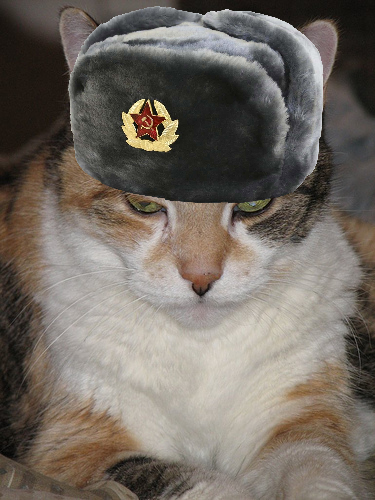

In [38]:
hat2 = hat.resize(get_size(head)).rotate(get_angle(pt))
im.paste(hat2, head, hat2)
im